In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from pyimzml.ImzMLParser import ImzMLParser

In [2]:
# If data is available
SM_file = '/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/a4-root mean square.imzML'
p = ImzMLParser(SM_file)

/home/duan/miniconda3/envs/spatialmeta/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/duan/miniconda3/envs/spatialmeta/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/duan/miniconda3/envs/spatialmeta/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


In [3]:
adata = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/9AA_A4_uMAIA_raw.h5ad")
#adata.var.columns = ['m/z']
adata.var_names = adata.var['m/z'].round(5).map('{:.5f}'.format)
adata.var

/home/duan/miniconda3/envs/spatialmeta/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


m/z
m/z                 
295.08566  295.08566
295.14077  295.14077
296.05593  296.05593
296.08098  296.08098
296.11605  296.11605
...              ...
422.13926  422.13926
832.50836  832.50836
833.51203  833.51203
834.52572  834.52572
834.57248  834.57248

[1000 rows x 1 columns]

/home/duan/miniconda3/envs/spatialmeta/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


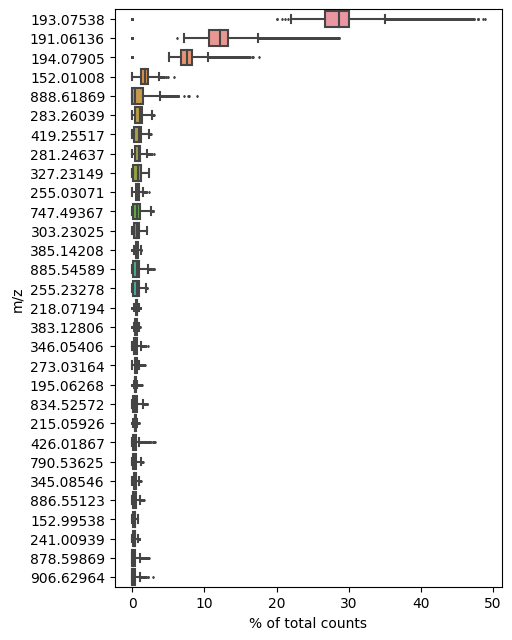

In [4]:
sc.pl.highest_expr_genes(adata)

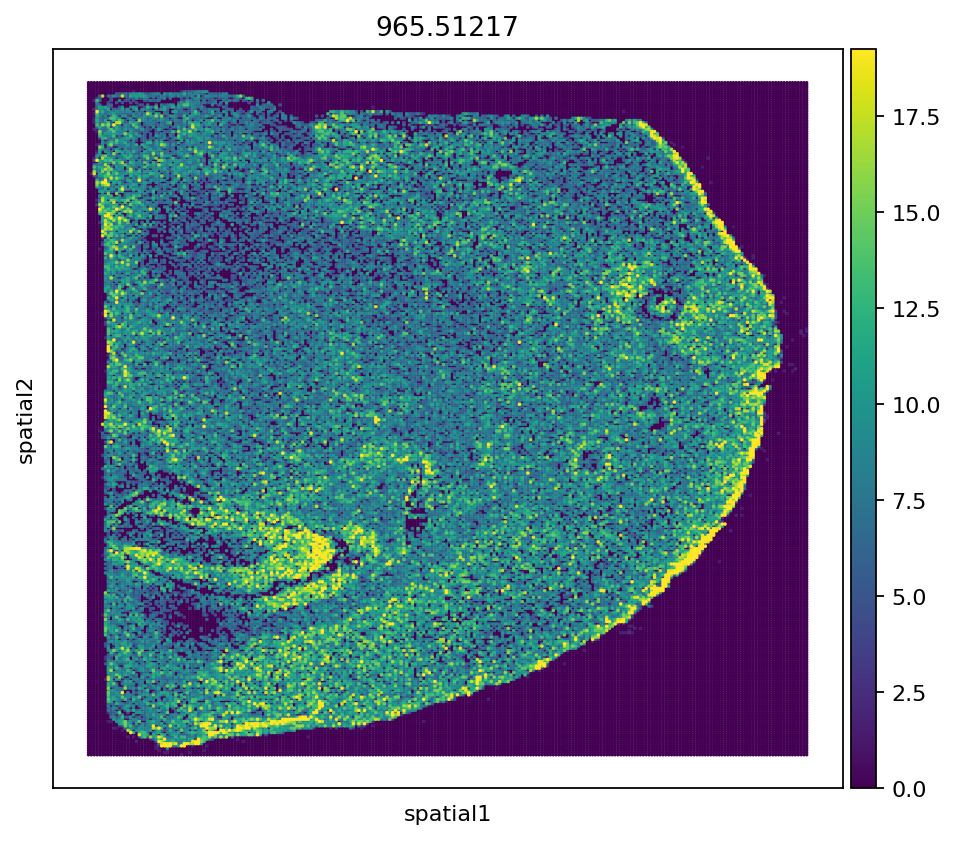

In [5]:
sc.set_figure_params(figsize = (7,6), scanpy = False)
sc.pl.embedding(adata, basis = 'spatial', color = '965.51217', vmax = 'p99', size = 10)

In [6]:
coords = np.array(p.coordinates)[:,0:2]

In [7]:
len(coords)

63506

In [8]:
ref_dict = {tuple(coord): True for coord in coords}

mask = np.array([ref_dict.get(tuple(coord), False) for coord in adata.obsm['spatial']])

In [9]:
adata.obs['Scanned'] = mask

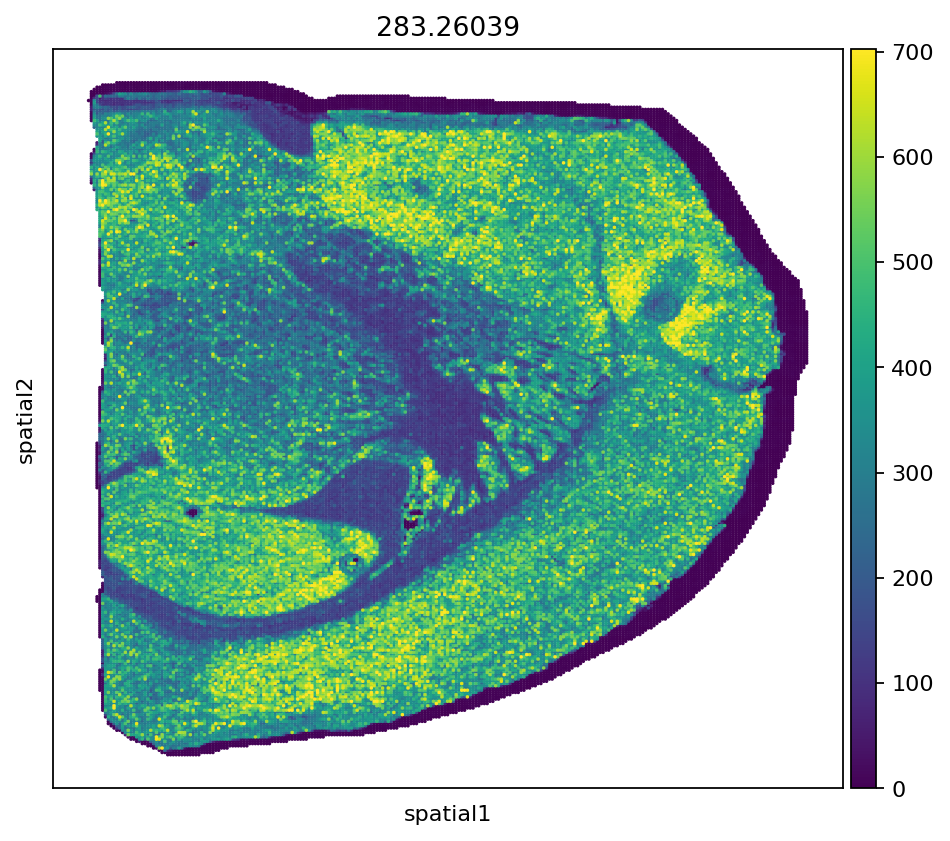

In [10]:
sc.pl.embedding(adata[adata.obs['Scanned']], basis = 'spatial', color = '283.26039', size = 10, vmax = 'p99')

In [11]:
adata = adata[adata.obs['Scanned']].copy()

In [12]:
adata.write_h5ad("MALDI/9AA_A4_uMAIA_scanned.h5ad")

In [1]:
from spatialdata import read_zarr
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tifffile

/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
adata = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/9AA_A4_uMAIA_scanned.h5ad")
adata.var.columns = ['m/z']
adata.var_names = adata.var['m/z'].round(5).map('{:.5f}'.format)

/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [ ]:
adata.var

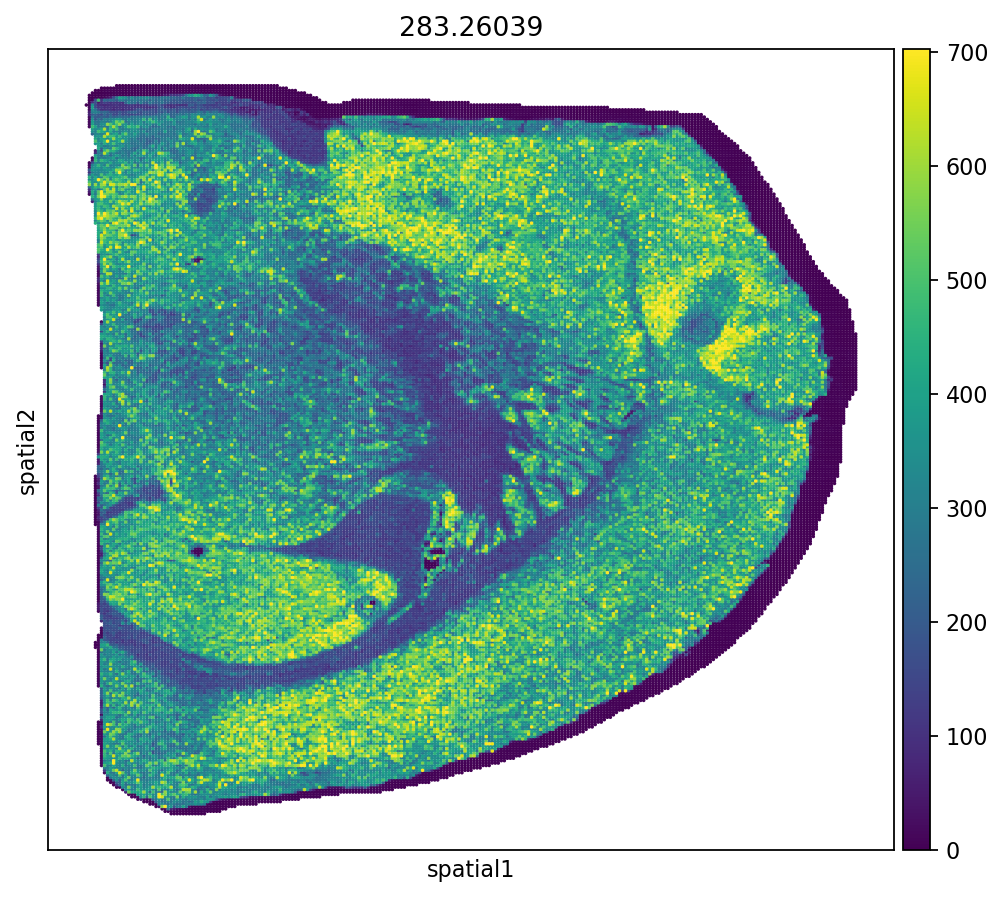

In [3]:
sc.set_figure_params(figsize = (7.5,6.5), scanpy = False)
sc.pl.embedding(adata, basis = 'spatial', color = '283.26039', size = 10, vmax = 'p99')

In [4]:
scaler = MinMaxScaler((10000, 60000))

In [5]:
intensity = adata.to_df()['283.26039'].to_numpy().reshape(-1,1)

In [6]:
intensity = np.clip(intensity, 0, np.percentile(intensity, 99.9))

In [7]:
intensity = scaler.fit_transform(intensity)

In [9]:
adata.obs['x_raw'] = adata.obsm['spatial'][:,0] 
adata.obs['y_raw'] = adata.obsm['spatial'][:,1] 

In [10]:
adata.obs['x_scaled'] = (adata.obs['x_raw'])* 61.54
adata.obs['y_scaled'] = (adata.obs['y_raw'])* 61.54

In [11]:
adata.obs = adata.obs.reset_index(drop = True)

In [12]:
adata.obs['x_scaled'] = adata.obs['x_scaled'] + 1000

In [13]:
1843 * 9

16587

In [17]:
m_img = np.zeros(shape = (20000, 16000))

In [18]:
for idx ,row in adata.obs.iterrows():
    x = row['x_scaled']
    y = row['y_scaled']
    
    x1 = int(min(16000, x))
    x2 = int(min(16000, x + 20))
    y1 = int(min(20000, y))
    y2 = int(min(20000, y + 20))
    
    if not x1 == x2 or y1 == y2:
        m_img[y1:y2, x1:x2] = intensity[int(idx)]

In [19]:
m_img = m_img.astype(np.uint16)

In [20]:
#tifffile.imwrite("DHB_20um_alignment/813.68579.tif", m_img)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7321fdb83790>)

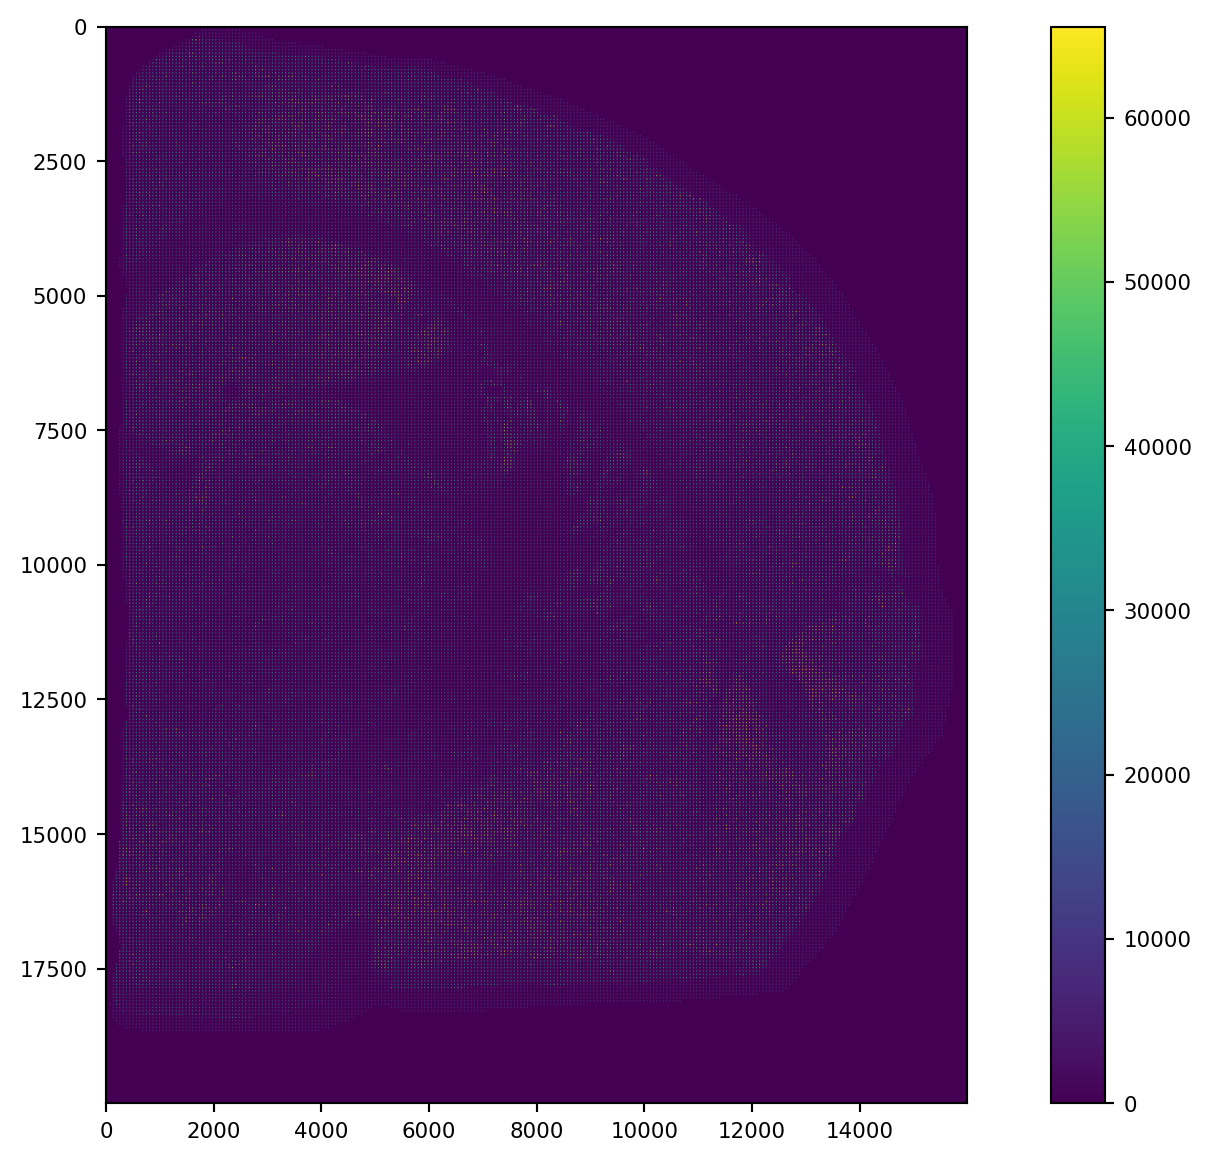

In [21]:
tifffile.imshow(m_img)

In [22]:
adata

AnnData object with n_obs × n_vars = 63461 × 1000
    obs: 'Scanned', 'x_raw', 'y_raw', 'x_scaled', 'y_scaled'
    var: 'm/z'
    uns: 'img_shape'
    obsm: 'spatial'

In [23]:
m_img.shape

(20000, 16000)

In [24]:
tiles = []
x_pos = []
y_pos = []

In [26]:
m = 0

for x_step in range(round(20000/1843)):
    for y_step in range(round(16000/1843)):

        x_start = x_step * 1843
        y_start = y_step * 1843
        
        x_end = min(x_start + 2048, 20000)
        y_end = min(y_start + 2048, 16000)

        tmp_img = m_img[x_start: x_end,y_start: y_end]

        if np.sum(tmp_img) > 0:
            tifffile.imwrite(f"/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/tiles/{m}.tif", tmp_img)

            tiles.append(m)
            x_pos.append(x_start)
            y_pos.append(y_start)

            m += 1

In [27]:
import pandas as pd

GLOBAL_GRID = pd.DataFrame({
    'tile': tiles,
    'x_pos': x_pos,
    'y_pos': y_pos
})

In [28]:
GLOBAL_GRID.to_csv("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/Grid.csv")

In [29]:
del adata.var['m/z']

In [30]:
adata.write_h5ad("MALDI/9AA_A4_uMAIA_scanned.h5ad")

In [8]:
import scanpy as sc
adata = sc.read_h5ad("MALDI/9AA_A4_uMAIA_scanned.h5ad")
adata.var

/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Empty DataFrame
Columns: []
Index: [295.08566, 295.14077, 296.05593, 296.08098, 296.11605, 296.19788, 297.00950, 297.03622, 297.06461, 348.11150, 349.01497, 349.06340, 368.11643, 368.19325, 368.95477, 369.01656, 369.04161, 369.07835, 369.11676, 178.02701, 178.06375, 179.01064, 179.04738, 179.08245, 179.11919, 302.96472, 303.07828, 303.23025, 304.07527, 525.12649, 525.18327, 527.12214, 579.14431, 579.20276, 579.29127, 285.06733, 285.10240, 286.00420, 287.03459, 287.05964, 287.08135, 523.03899, 523.11080, 523.16925, 524.18294, 524.27646, 790.53625, 791.46310, 791.53825, 792.46176, 218.03520, 218.07194, 219.98910, 473.15609, 474.16978, 205.07600, 206.07132, 206.94139, 207.09169, 581.15666, 581.17837, 581.30696, 965.51217, 653.29732, 765.52132, 766.53668, 767.46353, 756.58682, 493.04913, 493.13096, 493.16436, 494.13630, 881.51451, 558.06056, 560.13971, 561.11165, 561.18179, 562.19214, 562.25059, 740.51808, 742.43858, 613.14217, 203.04695, 203.07367, 204.06732, 857.51494, 857.56504, 543.14412, 402.99271, 403.10126, 403.25824, 404.10660, 619.16920, 619.28610, 277.97985, 278.07003, 279.07871, 279.14551, 279.23068, 370.13212, ...]

[1000 rows x 0 columns]

## 在Napari上将每一张小图手动对齐到OpenFISH的DIC图像上，然后保存变换矩阵。在把变换应用的点坐标之前，先将每一张小图中的点起始坐标移动到0,0，即减去MIST_GRID中定义的位置

In [9]:
import pandas as pd
transform_df = pd.read_excel("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/transformation_matrix.xlsx", header = None)
transform_df

0                                                  1
0    0  {"affine": [[0.996762934478254, 0.005564494678...
1    1  {"affine": [[0.9919821715474835, 0.00458424639...
2    2  {"affine": [[0.9992427855706809, 0.00901319601...
3    3  {"affine": [[1.0004262804008335, 0.00327125590...
4    4  {"affine": [[1.0065832718886214, 0.00516831114...
..  ..                                                ...
80  80  {"affine": [[0.9971012433668552, 0.00655698323...
81  81  {"affine": [[0.9953234659108912, 0.0, 16549.31...
82  82  {"affine": [[1.0093543101296345, 0.00580773003...
83  83  {"affine": [[0.9999879666679304, 0.00490576388...
84  84  {"affine": [[0.9999234667886663, 0.00418490393...

[85 rows x 2 columns]

In [10]:
import ast

In [11]:
adata.obs['x_scaled_aligned'] = -1.
adata.obs['y_scaled_aligned'] = -1.

In [12]:
GLOBAL_GRID = pd.read_csv("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/Grid.csv", index_col=0)
GLOBAL_GRID.head()

tile  x_pos  y_pos
0     0      0      0
1     1      0   1843
2     2      0   3686
3     3      0   5529
4     4      0   7372

In [13]:
import numpy as np

In [14]:
for m, row in GLOBAL_GRID.iterrows():

    # 1. 先只保留小图的区域
    mask = (adata.obs['x_scaled'] >= row['y_pos'])&(adata.obs['x_scaled'] < row['y_pos'] + 2048)&(adata.obs['y_scaled'] >= row['x_pos'])&(adata.obs['y_scaled'] < row['x_pos'] + 2048)
    
    x_img = adata.obs['x_scaled'][mask].values
    y_img = adata.obs['y_scaled'][mask].values

    # 2. 然后将坐标移动到0点

    x_img = x_img - row['y_pos']
    y_img = y_img - row['x_pos']

    # 3. 构造齐次坐标 (N, 3)
    points_h = np.stack([y_img,x_img, np.ones_like(x_img)], axis=1)  # shape (N, 3)
    
    # 4. 应用仿射变换
    H = ast.literal_eval(transform_df.loc[m, 1][11:-1])
    
    transformed_h = (H @ points_h.T).T  # shape (N, 3)
    
    # 5. 转回非齐次坐标
    x_img_aligned = transformed_h[:, 0] / transformed_h[:, 2]
    y_img_aligned = transformed_h[:, 1] / transformed_h[:, 2]

    # 6. 保存结果
    adata.obs.loc[mask, 'x_scaled_aligned'] = y_img_aligned
    adata.obs.loc[mask, 'y_scaled_aligned'] = x_img_aligned

In [15]:
adata.obsm['spatial_aligned'] = adata.obs[['x_scaled_aligned', 'y_scaled_aligned']].to_numpy()

In [16]:
adata = adata[(adata.obs['x_scaled_aligned'] >= 0)&(adata.obs['y_scaled_aligned'] >= 0)].copy()

In [17]:
m_img = np.zeros(shape = (20000, 16000))

In [18]:
import tifffile

In [19]:
for idx ,row in adata.obs.iterrows():
    x = row['x_scaled_aligned']
    y = row['y_scaled_aligned']
    
    x1 = int(min(16000, x))
    x2 = int(min(16000, x + 20))
    y1 = int(min(20000, y))
    y2 = int(min(20000, y + 20))
    
    if not x1 == x2 or y1 == y2:
        m_img[y1:y2, x1:x2] = intensity[int(idx)]

In [20]:
m_img = m_img.astype(np.uint16)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x78a53c359b10>)

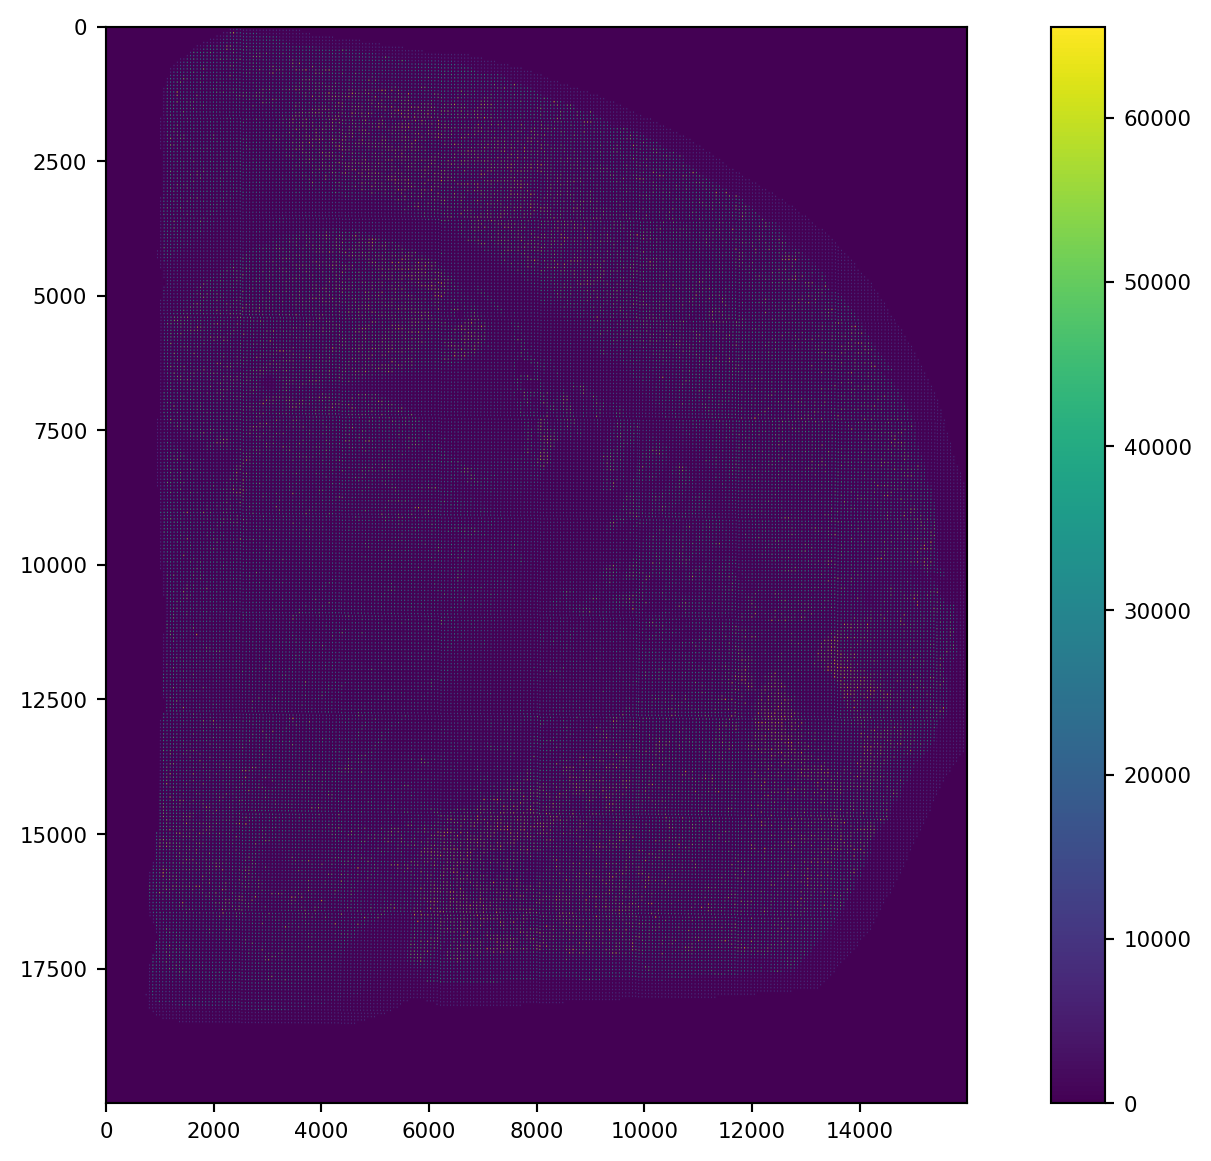

In [21]:
tifffile.imshow(m_img)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7779842d43d0>)

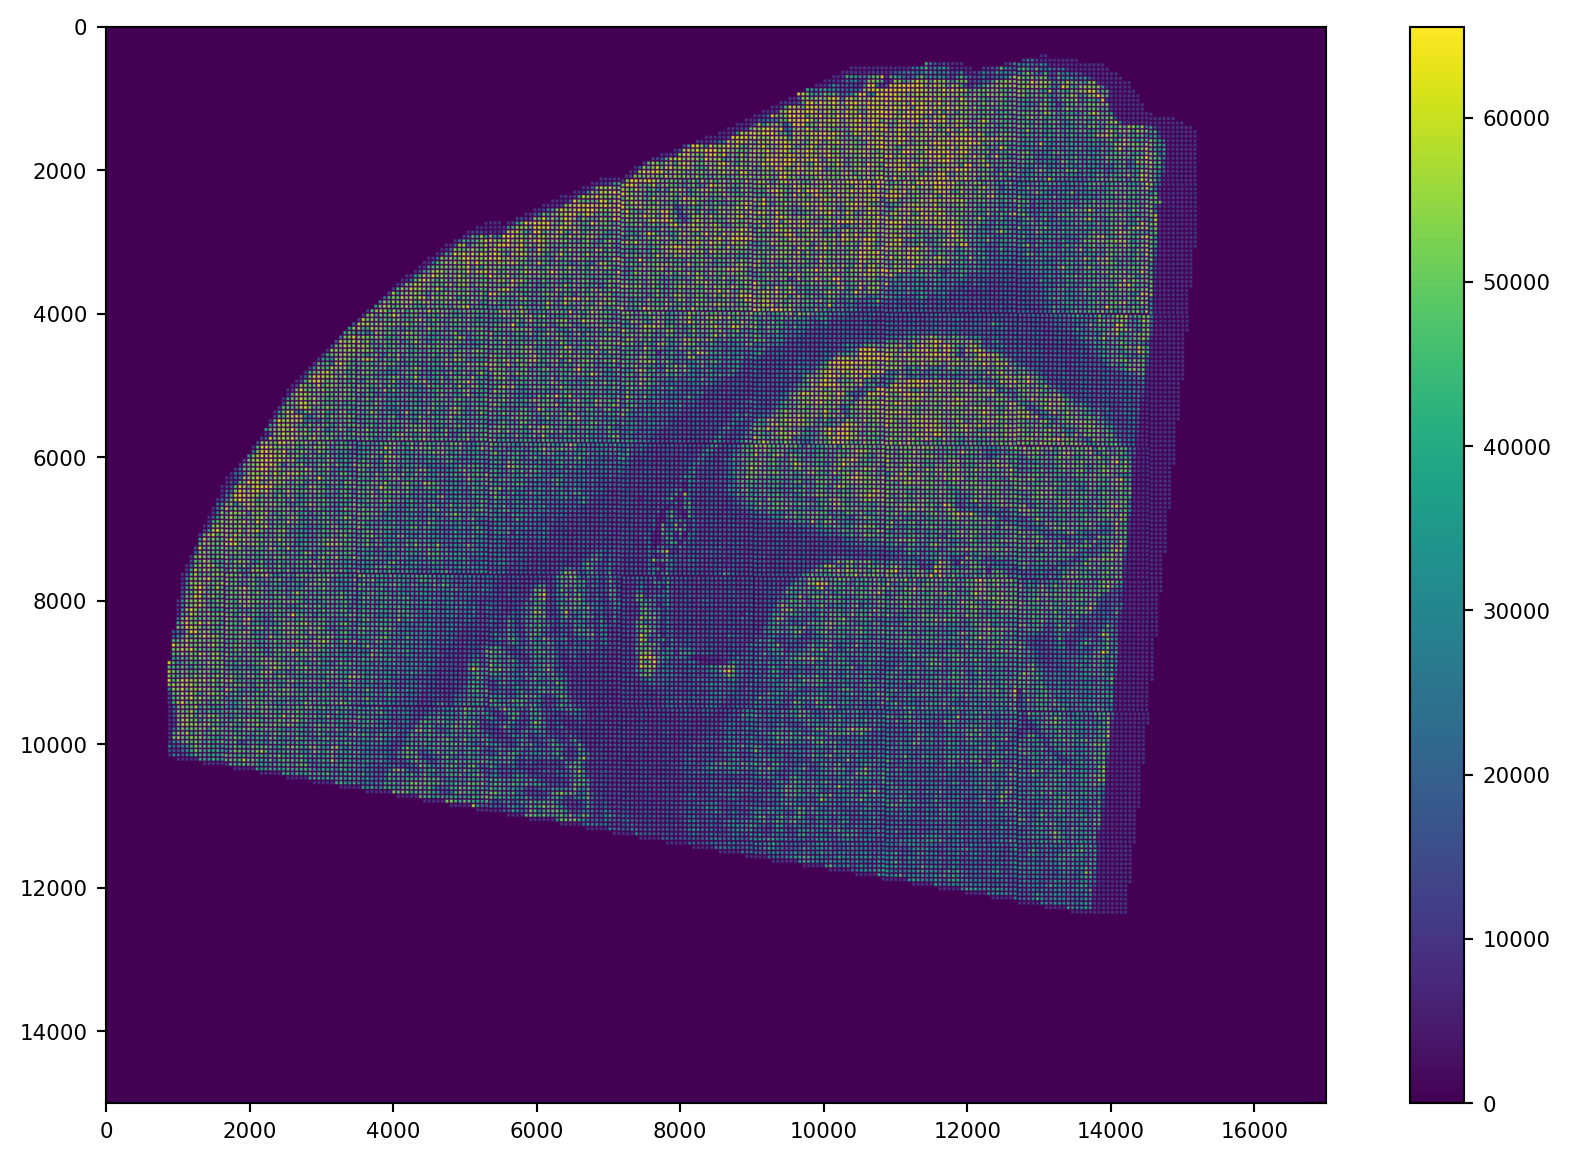

In [69]:
tifffile.imshow(m_img)

In [22]:
tifffile.imwrite("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/Aligned_283.26373.tif", m_img)

In [17]:
adata.write_h5ad("MALDI/9AA_A4_uMAIA_aligned.h5ad")